In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [3]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [16]:
torch.sign(torch.randint(-10, 10, (10,))).dtype

torch.int64

In [4]:
root='./data'
download=True
batch_size=1
shuffle=False
include_last_if_uneven=True
binarise_thesh=0.5

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thesh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thesh=binarise_thesh,
)

In [5]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

 23%|██▎       | 2326/10000 [00:00<00:00, 11835.22it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[False, False, False, False, False, False, False,  True, False, False]])


100%|██████████| 10000/10000 [00:00<00:00, 12081.91it/s]


In [6]:
len(test_MNIST_loader), len(train_MNIST_loader)

(10000, 60000)

In [7]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [8]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [9]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [10]:
dims = [INPUT_DIM, 128, 128, 64, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [11]:
loss_func: bnn.loss.LossFunction = bnn.loss.CrossEntropyLoss

In [12]:
output = -torch.ones(3, 3).to(int)
output[..., 0:2] = -1

target = torch.zeros(3, 3).to(bool)
target[..., 0] = True

In [337]:
output[:2], target[:2]

(tensor([[-1, -1, -1],
         [-1, -1, -1]]),
 tensor([[ True, False, False],
         [ True, False, False]]))

In [338]:
loss_func.forward(output, target)

tensor(1.0986, dtype=torch.float64)

In [339]:
loss_func.backward(output, target)

tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])

In [340]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.0001)

In [341]:
losses = []

In [342]:
train_epochs = 50
num_logs = train_epochs
epoch_log_rate = train_epochs // num_logs

In [343]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        prop_flipped += BernOpt.step()

        # sum loss
        epoch_loss += loss

        break

    # save loss
    losses.append(epoch_loss)

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {loss}\tmean_prop_flipped: {mean_prop_flipped}')

    if early_exit:
        break

 56%|█████▌    | 28/50 [00:00<00:00, 150.60it/s]

epoch: 0	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 1	loss: 3.878142210645671	mean_prop_flipped: 1.5927624190226197e-05
epoch: 2	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 3	loss: 3.878142210645671	mean_prop_flipped: 2.38914381043287e-05
epoch: 4	loss: 3.878142210645671	mean_prop_flipped: 1.5927624190226197e-05
epoch: 5	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 6	loss: 3.878142210645671	mean_prop_flipped: 1.5927624190226197e-05
epoch: 7	loss: 3.878142210645671	mean_prop_flipped: 0.0
epoch: 8	loss: 3.878142210645671	mean_prop_flipped: 3.1855248380452394e-05
epoch: 9	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 10	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 11	loss: 3.878142210645671	mean_prop_flipped: 7.963812095113099e-06
epoch: 12	loss: 3.878142210645671	mean_prop_flipped: 1.5927624190226197e-05
epoch: 13	loss: 3.878142210645671	mean_prop_flipp

100%|██████████| 50/50 [00:00<00:00, 160.04it/s]

epoch: 37	loss: 3.7363659234770727	mean_prop_flipped: 0.0
epoch: 38	loss: 3.7363659234770727	mean_prop_flipped: 7.963812095113099e-06
epoch: 39	loss: 3.7363659234770727	mean_prop_flipped: 1.5927624190226197e-05
epoch: 40	loss: 3.7363659234770727	mean_prop_flipped: 7.963812095113099e-06
epoch: 41	loss: 3.7363659234770727	mean_prop_flipped: 0.0
epoch: 42	loss: 3.7363659234770727	mean_prop_flipped: 1.5927624190226197e-05
epoch: 43	loss: 3.7363659234770727	mean_prop_flipped: 7.963812095113099e-06
epoch: 44	loss: 1.736365923477073	mean_prop_flipped: 2.38914381043287e-05
epoch: 45	loss: 1.736365923477073	mean_prop_flipped: 1.5927624190226197e-05
epoch: 46	loss: 1.736365923477073	mean_prop_flipped: 7.963812095113099e-06
epoch: 47	loss: 1.736365923477073	mean_prop_flipped: 0.0
epoch: 48	loss: 1.736365923477073	mean_prop_flipped: 1.5927624190226197e-05
epoch: 49	loss: 1.736365923477073	mean_prop_flipped: 2.38914381043287e-05


In [344]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p)
        ds.append(d)

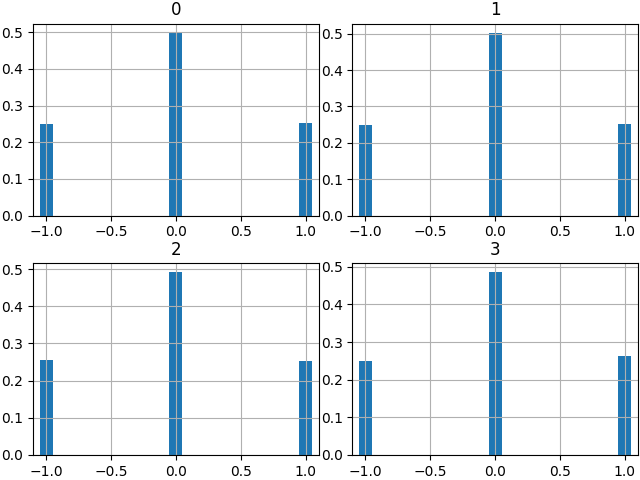

In [345]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

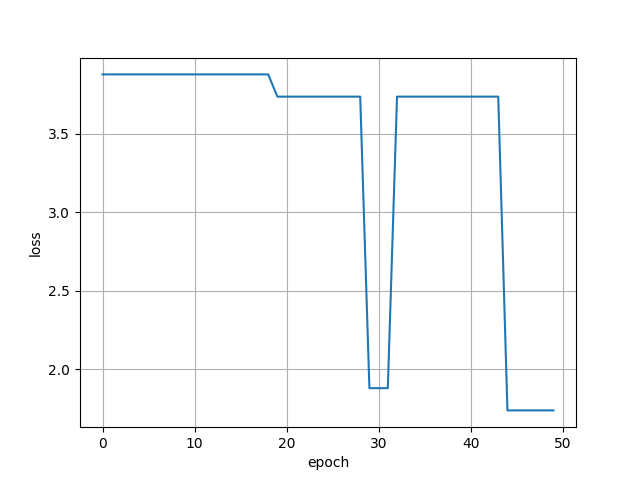

In [346]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [347]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 0,  1,  0,  ...,  1, -1,  0],
        [ 0,  1, -1,  ...,  0,  1,  0],
        [-1,  1,  0,  ...,  0, -1, -1],
        ...,
        [ 0, -1,  0,  ...,  0,  0,  0],
        [ 0,  0,  1,  ...,  0,  0,  1],
        [ 0, -1, -1,  ...,  1,  1,  0]], dtype=torch.int32) 
 tensor([[ 0,  0,  0,  ..., -1, -1,  0],
        [ 0,  0,  0,  ..., -1, -1,  0],
        [ 0,  0,  0,  ..., -1, -1,  0],
        ...,
        [ 0,  0,  0,  ..., -1, -1,  0],
        [ 0,  0,  0,  ..., -1, -1,  0],
        [ 0,  0,  0,  ..., -1, -1,  0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0, -1,  0,  ...,  0,  0,  0],
        [-1, -1,  0,  ...,  0,  1,  1],
        ...,
        [ 0,  0,  0,  ..., -1,  0,  1],
        [ 1,  1,  1,  ...,  0,  0,  1],
        [ 0,  1,  0,  ...,  1,  0,  0]], dtype=torch.int32) 
 tensor([[ 0,  0,  0,  ...,  0, -1,  0],
        [ 0,  0,  0,  ...,  0, -1,  0],
   

In [348]:
assert bnn.network.network_params_al_ternary(TBNN)